## Creating CF and ACDD compliant NetCDF file
*Author:* Corrado Motta - corradomotta92@gmail.com

This notebook aims to show how to add and possibly extract descriptive and administrative metadata from NetCDF files using python.
With descriptive metadata we mean all metadata that relates to Discovery and Identification in the FAIR principles. They usually includes info such as _title_, _author_, _subjects_, _keywords_, _publisher_, and _urls_. Examples of standards are __DataCite__, __DublinCore__, __ISO 19115__. They are mainly domain agnostic. On the other hand, administritive metadata are used to provide technical support for managing
data in a dataset. Such metadata are domain specific.

Useful links:
* [Notebook on FAIR and NetCDF](https://notebooks.githubusercontent.com/view/ipynb?color_mode=auto&commit=7438c171a8bfd838a97b9b859c8d92e0f9f01750&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f676973742f686576677972742f39663666613837383035643938636637386532356537373138616532336636622f7261772f373433386331373161386266643833386139376239623835396338643932653066396630313735302f6372656174655f4e65744344465f43465f414344442e6970796e62&logged_in=false&nwo=hevgyrt%2F9f6fa87805d98cf78e25e7718ae23f6b&path=create_NetCDF_CF_ACDD.ipynb&repository_id=99453764&repository_type=Gist)
* [Attribute Convention for Data Discovery](https://wiki.esipfed.org/Attribute_Convention_for_Data_Discovery_1-3)
* [CF Standard name table](https://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html)

In this notebook we show how to make a FAIR-compliant NECTDF file from raw data. We use two conventions to reach this goal:
* __CF__: Climate and Forecast convention. Mainly used for setting standard names to variables in NETCDF files and standard metadata for variables and dimensions.
* __ACDD__: Attribute for Climate and Data Discovery. It can be used together with CF to populate the global attributes of a .nc file. Some opensource software already exist to read the global attributes and automatically generate Dublin Core or ISO 19115 descriptive metadata.

Eventually, we also discuss how to generate/extract a XML file containg all the metadata following the ISO19115 standard schema.

### Table of Contents
* [1. Read configuration file](#read_cf)
* [2. Import raw data](#import_data)
* [3. Create NETCDF file with global metadata](#create_nc)
* [4. Read a NETCDF file and print metadata](#read_nc)
* [5. Export global metadata to ISO 19115 XML format](#export_iso)

### 1. Read configuration file <a class="anchor" id="read_cf"></a>
First of all we import all the needed packages.

In [28]:
# to read netcdf file
import netCDF4 as nc
# numpy is used to work with n-dimensional arrays
import numpy as np
# os miscellaneous
import os
# work with table
import pandas as pd
# to make figures
import matplotlib
# to work on netcdf files
import xarray
# to read conf file
import configparser
# to work with path
import ntpath
# to add date
from datetime import date
# to generate ISO19115
from bas_metadata_library.standards.iso_19115_2 import MetadataRecordConfigV2, MetadataRecord
# to read JSON database
from pysondb import PysonDB

All parameters are listed in the configuration file named _conf.ini_ in the conf folder. Let's read it using python and save the parameters into variables.

In [29]:
# read the conf file
read_config = configparser.ConfigParser()
read_config.read("conf/conf.ini")

# save params to variable
filePath = read_config.get("file_system_options", "raw_file_path")
resultPath = read_config.get("file_system_options", "result_path")
headerList = read_config.get("data_configuration", "header_list").split(',')

# Extract file name from the file path
filename = ntpath.split(filePath)[1].split(".")[0]

# print them 
if(filePath):
    print("Path to raw data: {0}. Extracted filename: {1}".format(filePath, filename))
else:
    print("Path not available")
if(resultPath):
    print("path to directory where to store data: {0}".format(resultPath))
else:
    print("Path not available")
    
# check if result directory exists otherwise create it
if(not os.path.exists(resultPath)):
    os.makedirs(resultPath)
    print("Created directory for storing results.")

Path to raw data: data/mpdacs-180601-141112.log. Extracted filename: mpdacs-180601-141112
path to directory where to store data: results


In [30]:
my_complete_dict = dict(read_config.items('mandatory_global_attributes'))
my_complete_dict = my_complete_dict | dict(read_config.items('optional_global_attributes'))

In [31]:
print("The following attributes will be added:")
cont = 0
key_list = []
for key, value in my_complete_dict.items():
    if(value):
        cont +=1
        key_list.append(key)
        print(str(cont) + ".", key, '->', value)

The following attributes will be added:
1. title -> Raw Data Svalbard 2019
2. summary -> Data collected during the Svalbard mission in 2019.
3. keywords -> ctd,depth,svalbard
4. conventions -> ACDD-1.3,CF-1.6
5. creator_name -> Motta, Corrado
6. creator_email -> mail@cnr
7. institution -> CNR-INM
8. date_created -> 2022-08-22T09:49:00+02:00
9. platform -> satellite
10. license -> None
11. standard_name_vocabulary -> NetCDF Climate and Forecast (CF) Metadata Convention Standard Name Table v79
12. creator_url -> https://www.cnr.it/
13. project -> INNOVAMARE


We want to check if the attributes specifed in the ini file satisfy the minimum set of mandatory global metadata that we stored in the JSON database, in the database folder. The JSON database is generated una tantum from a CSV table (check the "database" notebook for more information)

In [32]:
# Opening JSON file
global_db = PysonDB('database/global_metadata.json')

# iterate over mandatory global metadata. When one is not present, stop and print it
for key, value in global_db.get_all().items():
    if(value['required']):
        if(value['ACDD'].lower() in key_list):
            print(value['ACDD'] + ".. found")
        else:
            print(value['ACDD'], "NOT found!\n\nPlease add a value for ",value['ACDD'])
            break

title.. found
summary.. found
keywords.. found
Conventions.. found
creator_name.. found
creator_email.. found
institution.. found
time_coverage_start NOT found!

Please add a value for  time_coverage_start


### 2. Import raw data <a class="anchor" id="import_data"></a>
Let's import the data using read table method of pandas. We give as input the path, the delimiter as a single space, and the header list. We also set to not use the first column as index

In [6]:
data = pd.read_table(filePath, delimiter = ' ', index_col = False, names = headerList)

The shape method tell us the dimensions of the imported table. in python, you can simply check what a method does using the help function:

In [7]:
help(data.shape)

Help on tuple object:

class tuple(object)
 |  tuple(iterable=(), /)
 |  
 |  Built-in immutable sequence.
 |  
 |  If no argument is given, the constructor returns an empty tuple.
 |  If iterable is specified the tuple is initialized from iterable's items.
 |  
 |  If the argument is a tuple, the return value is the same object.
 |  
 |  Built-in subclasses:
 |      asyncgen_hooks
 |      RefResolutionErrorAttributes
 |      TypeCheckerAttributes
 |      UnraisableHookArgs
 |      ... and 1 other subclasses
 |  
 |  Methods defined here:
 |  
 |  __add__(self, value, /)
 |      Return self+value.
 |  
 |  __contains__(self, key, /)
 |      Return key in self.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(self, key, /)
 |      Return self[key].
 |  
 |  __getnewargs__(self, /)
 |  
 |  __gt__(self, value, /)
 |      

In [8]:
data.shape

(65756, 23)

Let's make a simple plot using two of the present variables. We can print all variable naimes:

In [9]:
# read all columns
data.columns

Index(['logDate', 'logTime', 'logNanoSeconds', 'turbidity', 'fluorescence',
       'arlocTime', 'arlocChlA1', 'arlocChlA2', 'arlocDepth',
       'arlocTemperature', 'arlocXIncl', 'arlocYIncl', 'arlocZAcc',
       'arlocGyro', 'arlocBattery', 'ctd305Conductivity', 'ctd305Temperature',
       'ctd305Depth', 'ctd305Salinity', 'ctd305O2Percent', 'ctd305O2Ppm',
       'ctd305O2Ph', 'ctd305O2Eh'],
      dtype='object')

We can then plot the fluorescence against the depth to check wether the data looks as expected

<AxesSubplot:xlabel='fluorescence'>

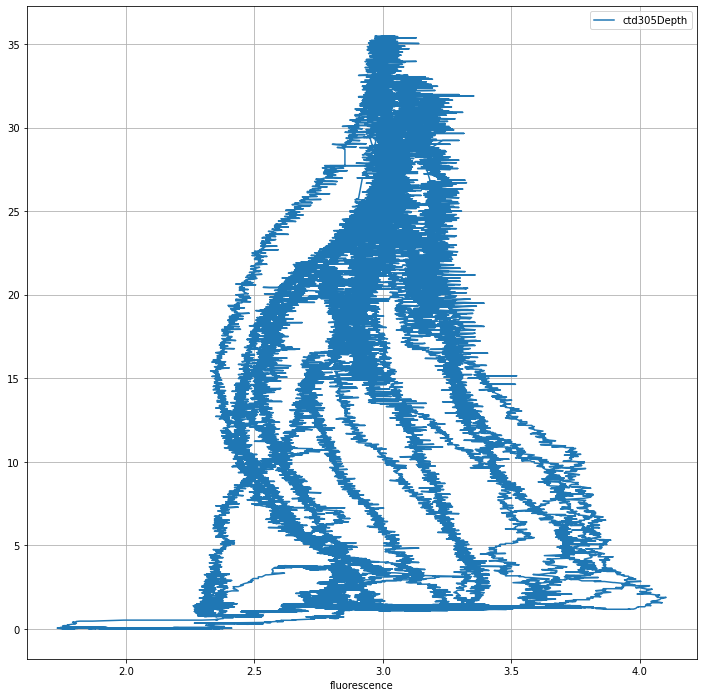

In [10]:
data.plot(x='fluorescence', y='ctd305Depth', figsize=(12,12), grid = True)

### 3. Create NETCDF file with global metadata <a class="anchor" id="create_nc"></a>
Now that we know the data looks OK, we can create a NETCDF out of them. We use the xarray package to do that. First we create an xarray object from the pandas data:

In [11]:
xr = xarray.Dataset.from_dataframe(data)

By printing it, we can already see that now it has assumed the format of a NETCDF file

In [12]:
xr

<xarray.Dataset>
Dimensions:             (index: 65756)
Coordinates:
  * index               (index) int64 0 1 2 3 4 ... 65752 65753 65754 65755
Data variables: (12/23)
    logDate             (index) int64 180601 180601 180601 ... 180601 180601
    logTime             (index) int64 141112 141112 141112 ... 141112 141112
    logNanoSeconds      (index) int64 100042136 200037136 ... 6575525961711
    turbidity           (index) float64 0.015 0.02 0.02 0.02 ... 0.02 0.02 0.015
    fluorescence        (index) float64 1.88 1.875 1.855 ... 2.012 2.012 2.012
    arlocTime           (index) int64 0 135920 135920 ... 153757 153757 153757
    ...                  ...
    ctd305Depth         (index) float64 0.0 0.0 0.0 0.08 ... 0.01 0.02 0.02 0.02
    ctd305Salinity      (index) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ctd305O2Percent     (index) float64 0.0 0.0 0.0 75.6 ... 65.8 65.8 65.8 65.8
    ctd305O2Ppm         (index) float64 0.0 0.0 0.0 8.93 ... 8.09 8.09 8.09 8.09
    ctd305O2Ph          (index) float64 0.0 0.0 0.0 7.128 ... 8.332 8.332 8.332
    ctd305O2Eh          (index) float64 0.0 0.0 0.0 6.5 ... 355.0 355.0 355.0

It is time to add the metadata stored in our configuration file to the Netcdf

In [14]:
for key, value in my_complete_dict.items():
    if(value):
        xr.attrs[key] = value

In [15]:
xr

<xarray.Dataset>
Dimensions:             (index: 65756)
Coordinates:
  * index               (index) int64 0 1 2 3 4 ... 65752 65753 65754 65755
Data variables: (12/23)
    logDate             (index) int64 180601 180601 180601 ... 180601 180601
    logTime             (index) int64 141112 141112 141112 ... 141112 141112
    logNanoSeconds      (index) int64 100042136 200037136 ... 6575525961711
    turbidity           (index) float64 0.015 0.02 0.02 0.02 ... 0.02 0.02 0.015
    fluorescence        (index) float64 1.88 1.875 1.855 ... 2.012 2.012 2.012
    arlocTime           (index) int64 0 135920 135920 ... 153757 153757 153757
    ...                  ...
    ctd305Depth         (index) float64 0.0 0.0 0.0 0.08 ... 0.01 0.02 0.02 0.02
    ctd305Salinity      (index) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ctd305O2Percent     (index) float64 0.0 0.0 0.0 75.6 ... 65.8 65.8 65.8 65.8
    ctd305O2Ppm         (index) float64 0.0 0.0 0.0 8.93 ... 8.09 8.09 8.09 8.09
    ctd305O2Ph          (index) float64 0.0 0.0 0.0 7.128 ... 8.332 8.332 8.332
    ctd305O2Eh          (index) float64 0.0 0.0 0.0 6.5 ... 355.0 355.0 355.0
Attributes: (12/13)
    title:                     Raw Data Svalbard 2019
    summary:                   Data collected during the Svalbard mission in ...
    keywords:                  ctd,depth,svalbard
    conventions:               ACDD-1.3,CF-1.6
    creator_name:              Motta, Corrado
    creator_email:             mail@cnr
    ...                        ...
    date_created:              2022-08-22T09:49:00+02:00
    platform:                  satellite
    license:                   None
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    creator_url:               https://www.cnr.it/
    project:                   INNOVAMARE

Now we can save it as a NETCDF with the following function:

In [16]:
# create a result path for it
result_path = os.path.join(resultPath, filename + ".nc")

# save to nc
xr.to_netcdf(result_path)
print("saved to {0}".format(result_path))

saved to results\mpdacs-180601-141112.nc


### 4. Read a NETCDF file and print metadata <a class="anchor" id="read_nc"></a>
To read the NETCDF we use the homonym python package

In [17]:
ds = nc.Dataset(result_path)
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Raw Data Svalbard 2019
    summary: Data collected during the Svalbard mission in 2019.
    keywords: ctd,depth,svalbard
    conventions: ACDD-1.3,CF-1.6
    creator_name: Motta, Corrado
    creator_email: mail@cnr
    institution: CNR-INM
    date_created: 2022-08-22T09:49:00+02:00
    platform: satellite
    license: None
    standard_name_vocabulary: NetCDF Climate and Forecast (CF) Metadata Convention Standard Name Table v79
    creator_url: https://www.cnr.it/
    project: INNOVAMARE
    dimensions(sizes): index(65756)
    variables(dimensions): int64 index(index), int64 logDate(index), int64 logTime(index), int64 logNanoSeconds(index), float64 turbidity(index), float64 fluorescence(index), int64 arlocTime(index), int64 arlocChlA1(index), int64 arlocChlA2(index), int64 arlocDepth(index), int64 arlocTemperature(index), int64 arlocXIncl(index), int64 arlocYIncl(index), int64 arlocZAcc(in

As an alternative we can use xarray as well

In [18]:
ds_disk = xarray.open_dataset(result_path)

In [19]:
ds_disk

<xarray.Dataset>
Dimensions:             (index: 65756)
Coordinates:
  * index               (index) int64 0 1 2 3 4 ... 65752 65753 65754 65755
Data variables: (12/23)
    logDate             (index) int64 ...
    logTime             (index) int64 ...
    logNanoSeconds      (index) int64 ...
    turbidity           (index) float64 ...
    fluorescence        (index) float64 ...
    arlocTime           (index) int64 ...
    ...                  ...
    ctd305Depth         (index) float64 ...
    ctd305Salinity      (index) float64 ...
    ctd305O2Percent     (index) float64 ...
    ctd305O2Ppm         (index) float64 ...
    ctd305O2Ph          (index) float64 ...
    ctd305O2Eh          (index) float64 ...
Attributes: (12/13)
    title:                     Raw Data Svalbard 2019
    summary:                   Data collected during the Svalbard mission in ...
    keywords:                  ctd,depth,svalbard
    conventions:               ACDD-1.3,CF-1.6
    creator_name:              Motta, Corrado
    creator_email:             mail@cnr
    ...                        ...
    date_created:              2022-08-22T09:49:00+02:00
    platform:                  satellite
    license:                   None
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    creator_url:               https://www.cnr.it/
    project:                   INNOVAMARE

Let's print the available global attributes

In [20]:
for key, value in ds_disk.attrs.items() :
    print(key + ": " + str(value))

title: Raw Data Svalbard 2019
summary: Data collected during the Svalbard mission in 2019.
keywords: ctd,depth,svalbard
conventions: ACDD-1.3,CF-1.6
creator_name: Motta, Corrado
creator_email: mail@cnr
institution: CNR-INM
date_created: 2022-08-22T09:49:00+02:00
platform: satellite
license: None
standard_name_vocabulary: NetCDF Climate and Forecast (CF) Metadata Convention Standard Name Table v79
creator_url: https://www.cnr.it/
project: INNOVAMARE


We can also define a simple function to read a single attribute on demand and one to return a variable object.

In [21]:
def getAttribute(myds, attribute):
    # return the value of the attribute given as argument
    
    my_attr = None
    try:
         my_attr = getattr(myds, attribute)
    except AttributeError as e: 
        print("arg <{0}> not present in the .nc file".format(attribute))
    return my_attr

def getVariable(myds, variable):
    # return the object of the variable given as argument
    return myds.variables.get(variable, None)
        

In [22]:
# geospatial_lat_max
my_attr = "summary"
print(getAttribute(ds, my_attr))

Data collected during the Svalbard mission in 2019.


Let's check all variable names

In [23]:
list(ds.variables.keys())

['index',
 'logDate',
 'logTime',
 'logNanoSeconds',
 'turbidity',
 'fluorescence',
 'arlocTime',
 'arlocChlA1',
 'arlocChlA2',
 'arlocDepth',
 'arlocTemperature',
 'arlocXIncl',
 'arlocYIncl',
 'arlocZAcc',
 'arlocGyro',
 'arlocBattery',
 'ctd305Conductivity',
 'ctd305Temperature',
 'ctd305Depth',
 'ctd305Salinity',
 'ctd305O2Percent',
 'ctd305O2Ppm',
 'ctd305O2Ph',
 'ctd305O2Eh']

And print a single variable

In [24]:
my_var = "ctd305O2Ppm"
obj_var = getVariable(ds, my_var)
obj_var

<class 'netCDF4._netCDF4.Variable'>
float64 ctd305O2Ppm(index)
    _FillValue: nan
unlimited dimensions: 
current shape = (65756,)
filling on

In [25]:
my_var = "ctd305Temperature"
obj_var = getVariable(ds, my_var)
obj_var

<class 'netCDF4._netCDF4.Variable'>
float64 ctd305Temperature(index)
    _FillValue: nan
unlimited dimensions: 
current shape = (65756,)
filling on

### 4. Export global metadata to ISO 19115 XML format <a class="anchor" id="export_iso"></a>

The metadata set in the conf.ini file are then added to the NETCDF4 using ACDD. However, we also want to be able to generate a ISO 199115 compliant metadata file, in the XML format. In fact, this is required by many different online repositories. 

Mapping between ACDD and ISO 19115 is provided [here](https://wiki.esipfed.org/Attribute_Convention_for_Data_Discovery_Mappings).

__Note:__ this is under development. Right now, a python software packet named [bas-metadata-library](https://pypi.org/project/bas-metadata-library/) is used to generate the ISO file. This is done from the conf.ini list and not directly from the NETCDF4, which would be a more auspicable solution.

In [27]:
# set contact
if(my_complete_dict["creator_name"]):
    individual_contact = [{"individual": {"name": my_complete_dict["creator_name"]}, "role": ["originator"]}]
else:
    print("not implemented yet")
    
    
minimal_record_config = {
    "hierarchy_level": "dataset",
    "metadata": {
        "language": "eng",
        "character_set": "utf-8",
        "contacts": individual_contact,
        "date_stamp": date(2018, 10, 18),
    },
    "identification": {
        "title": {"value": my_complete_dict['title']},
        "dates": {"creation": {"date": date(2018, 1, 1), "date_precision": "year"}},
        "abstract": my_complete_dict['summary'],
        "keywords":[{"terms":[{"term": item} for item in my_complete_dict['keywords'].split(",")]}],
        "character_set": "utf-8",
        "language": "eng",
        "topics": ["geoscientificInformation"],
        "extent": {
            "geographic": {
                "bounding_box": {
                    "west_longitude": -45.61521,
                    "east_longitude": -27.04976,
                    "south_latitude": -68.1511,
                    "north_latitude": -54.30761,
                }
            }
        },
    },
}
configuration = MetadataRecordConfigV2(**minimal_record_config)
record = MetadataRecord(configuration=configuration)
document = record.generate_xml_document()

# output document
result_path = os.path.join(resultPath, filename + "_metadata.xml")
# print(document.decode())
f = open(result_path, "w")
f.write(document.decode())
f.close()
print("metadata saved in", result_path)

metadata saved in results\mpdacs-180601-141112_metadata.xml
